# 0. Preparation

In [1]:
# For adjusting points to get correct flowdepth
# Packages for transformation
from numba import njit, guvectorize, float64                         # For speeding up the time of the code running

# Packages for unrotating and untranslating
from osgeo import gdal                                               # For manipulating rasters (calculating centers)

# For handling raster
import numpy as np                                                   # For all calculation and data array/matrices manipulation
import rioxarray                                                     # For opening and reading raster files and manipulating pixel values and spatial attributes
import xarray                                                        # For writing arrays into raster files
import rasterio                                                      # For opening and reading raster files and manipulating transformation and crs

# For handling polygons
import fiona                                                         # For reading shape file under GeoJSON format
from shapely.geometry import shape                                   # For converting geometry data into shapely geometry format
from rtree import index                                              # For using spatial index function
import geopandas as gpd                                              # For manipulating geospatial data under polygon format
import pandas as pd                                                  # For manipulating dataframe
from shapely.geometry import Point                                   # For converting point coordinates into shapely geometry point

# For plotting
import matplotlib.pyplot as plt                                      # For plotting contour and scatter
import matplotlib.cm as cm                                           # For changing color
import contextily as ctx                                             # For adding basemap

# For other things
import os                                                            # For creating new folders
import pathlib                                                       # For getting path
import time                                                          # For timing steps

# For coloring
import matplotlib.colors as mcolors                                  # For coloring
from matplotlib_scalebar.scalebar import ScaleBar                    # For scale bar

In [2]:
# Remove all warnings
# Reference: https://numba.pydata.org/numba-doc/dev/reference/deprecation.html#suppressing-deprecation-warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

In [3]:
# Assign the name you have just created for the drive
drive = "S"
main_folder = "MULTIPLE_TILES_Monte_Carlo_BGFLOOD"
version = "version_6"
header = f"{drive}:\\{main_folder}\\{version}"

# Create header path
pathlib.Path(f"{header}").mkdir(parents=True, exist_ok=True)

In [4]:
# Create paths

#--------------------------------------------------- This is for TRANSFORMATION PART -------------------------------------------


# 0_open_topography: Folder stores ownloaded lidar point cloud data from open topography website
# Reference: https://portal.opentopography.org/datasets
original_lidar_path = f"{header}\\0_open_topography"

# 1_modified_lidar: Folder stores ownloaded lidar point cloud data from open topography website
modified_lidar_path = f"{header}\\1_modified_lidar"

# 2_transformation: Folder stores transformed lidar point cloud data
rotated_lidar_path = f"{header}\\2_transformation\\rotated_lidar"
translated_lidar_path = f"{header}\\2_transformation\\translated_lidar"
combined_lidar_path = f"{header}\\2_transformation\\combined_lidar"

# 3_dem_raster: Folder stores DEM rasters
# Rotation
# Netcdf
rotated_nc_raster_path = f"{header}\\3_dem_raster\\rotated_dem_raster\\rot_dem_raster\\rot_netcdf"
# GeoTiff
rotated_tiff_raster_path = f"{header}\\3_dem_raster\\rotated_dem_raster\\rot_dem_raster\\rot_tiff"
# Ascii
rotated_asc_raster_path = f"{header}\\3_dem_raster\\rotated_dem_raster\\rot_dem_raster\\rot_ascii"
rotated_elements_path = f"{header}\\3_dem_raster\\rotated_dem_raster\\rot_elements"

# Translation
# Netcdf
translated_nc_raster_path = f"{header}\\3_dem_raster\\translated_dem_raster\\tra_dem_raster\\tra_netcdf"
# GeoTiff
translated_tiff_raster_path = f"{header}\\3_dem_raster\\translated_dem_raster\\tra_dem_raster\\tra_tiff"
# Ascii
translated_asc_raster_path = f"{header}\\3_dem_raster\\translated_dem_raster\\tra_dem_raster\\tra_ascii"
translated_elements_path = f"{header}\\3_dem_raster\\translated_dem_raster\\tra_elements"

# Combination
# Netcdf
combined_nc_raster_path = f"{header}\\3_dem_raster\\combined_dem_raster\\com_dem_raster\\com_netcdf"
# GeoTiff
combined_tiff_raster_path = f"{header}\\3_dem_raster\\combined_dem_raster\\com_dem_raster\\com_tiff"
# Ascii
combined_asc_raster_path = f"{header}\\3_dem_raster\\combined_dem_raster\\com_dem_raster\\com_ascii"
combined_elements_path = f"{header}\\3_dem_raster\\combined_dem_raster\\com_elements"

# 4_BG_Flood: Folder stores BG_Flood outputs and Flowdepth outputs
# BG_Flood output
rotated_BGoutput_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\rotation\\rotated_BGoutput"
translated_BGoutput_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\translation\\translated_BGoutput"
combined_BGoutput_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\combination\\combined_BGoutput"

# BG_Flood param
rotated_BGparam_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\rotation\\rotated_BGparam"
translated_BGparam_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\translation\\translated_BGparam"
combined_BGparam_path = f"{header}\\4_BG_Flood\\BG_Flood_output\\combination\\combined_BGparam"

# 5_flowdepth: Folder stores flowdepth extracted from BG-FLOOD output
rotated_flowdepth_path = f"{header}\\5_flowdepth\\rotated_flowdepth"
translated_flowdepth_path = f"{header}\\5_flowdepth\\translated_flowdepth"
combined_flowdepth_path = f"{header}\\5_flowdepth\\combined_flowdepth"

# 6_un_transformation: Folder stores un-transformed raster
# un_rotation
unrotated_crs_path = f"{header}\\6_un_transformation\\un_rotation\\unrotated_crs"
unrotated_path = f"{header}\\6_un_transformation\\un_rotation\\unrotated_shp"

# un_translation
untranslated_crs_path = f"{header}\\6_un_transformation\\un_translation\\untranslated_crs"
untranslated_path = f"{header}\\6_un_transformation\\un_translation\\untranslated_shp"

# un_combination
uncombined_crs_path = f"{header}\\6_un_transformation\\un_combination\\uncombined_crs"
uncombined_path = f"{header}\\6_un_transformation\\un_combination\\uncombined_shp"

#--------------------------------------------------- This is for ANALYSIS PART ------------------------------------------------

# 7_results: Folder stores mean and standard deviation
# Un_rotation
csv_rotation = f"{header}\\7_results\\un_rotation\\unrot_csv"
raster_rotation = f"{header}\\7_results\\un_rotation\\unrot_raster"
polygon_rotation = f"{header}\\7_results\\un_rotation\\unrot_polygon"
plot_rotation = f"{header}\\7_results\\un_rotation\\unrot_plot"

# Un_translation
csv_translation = f"{header}\\7_results\\un_translation\\untra_csv"
raster_translation = f"{header}\\7_results\\un_trfanslation\\untra_raster"
polygon_translation = f"{header}\\7_results\\un_translation\\untra_polygon"
plot_translation = f"{header}\\7_results\\un_translation\\untra_plot"

# Un_combination
csv_combination = f"{header}\\7_results\\un_combination\\uncom_csv"
raster_combination = f"{header}\\7_results\\un_combination\\uncom_raster"
polygon_combination = f"{header}\\7_results\\un_combination\\uncom_polygon"
plot_combination = f"{header}\\7_results\\un_combination\\uncom_plot"

In [5]:
# Create a list of all paths
neccessary_files = [
    # 0_open_topography
    original_lidar_path,
    
    # 1_modified_lidar
    modified_lidar_path,
    
    # 2_transformation
    rotated_lidar_path,
    translated_lidar_path,
    combined_lidar_path,
    
    # 3_dem_raster
    # Rotation
    rotated_nc_raster_path,
    rotated_tiff_raster_path,
    rotated_asc_raster_path,
    rotated_elements_path,
    
    # Translation
    translated_nc_raster_path,
    translated_tiff_raster_path,
    translated_asc_raster_path,
    translated_elements_path,
    
    # Combination
    combined_nc_raster_path,
    combined_tiff_raster_path,
    combined_asc_raster_path,
    combined_elements_path,
    
    # 4_BG_FLOOD
    rotated_BGoutput_path,
    translated_BGoutput_path,
    combined_BGoutput_path,
    
    # 5_flowdepth
    rotated_flowdepth_path,
    translated_flowdepth_path,
    combined_flowdepth_path,
    
    # 6_un_transformation
    # Unrotation
    unrotated_crs_path,
    unrotated_path,
    
    # Untranslation
    untranslated_crs_path,
    untranslated_path,
    
    # Uncombination
    uncombined_crs_path,
    uncombined_path,
    
    # 7_results
    # Unrotation
    csv_rotation,
    raster_rotation,
    polygon_rotation,
    plot_rotation,
    
    # Untranslation
    csv_translation,
    raster_translation,
    polygon_translation,
    plot_translation,
    
    # Uncombination
    csv_combination,
    raster_combination,
    polygon_combination,
    plot_combination
]

In [6]:
# Create folder
# Reference: https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-nested-directory-in-python
for each_folder in neccessary_files:
    pathlib.Path(f"{each_folder}").mkdir(parents=True, exist_ok=True)

# 1. Getting clipped dataset

In [7]:
# Create a function to get the full number of x, y values in raster array
def array_creation(data_array, value, shape_x, shape_y):
    '''This function is to create an array of a coordinate
    Argument:
                data_array:
                            Original array to extract values
                value:
                            The value of original array need extracting
                shape_x and shape_y:
                            Shape of the new array
    Return:
                new_array:
                            New array of the coordinate
    '''
    # Create zero array
    new_array = np.zeros((shape_x, shape_y))
    
    # Read x, y values into arrays
    arr_x = data_array.x.values
    arr_y = data_array.y.values
    
    # Get full number of x or y values
    for i in range(new_array.shape[0]):
        for j in range(new_array.shape[0]):
            if value == 'x':
                new_array[j,i] = arr_x[i]
            else:
                new_array[i,j] = arr_y[i]
                
    return new_array

In [8]:
# Create a function to get x, y, z of a rotated degree raster file
def xyz_array(transformation_selection, number, time):
    '''This function is to create an array from flowdepth raster including x, y, z values
    Reference: https://corteva.github.io/rioxarray/stable/examples/resampling.html
    Argument:
                transformation_selection:
                            "r" means rotation
                            "t" means translation
                            "c" means combination
                number:
                        Ordinal number of simulation
                time:
                        Amount of time that BG_flood model predicted
    Return:
                full_dataset:
                        A dataset contains 1D x, y, z array including padding
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        untransformed_path = unrotated_path
        flowdepth_path = rotated_flowdepth_path
    elif transformation_selection == 't':
        transformed = "translated"
        untransformed_path = untranslated_path
        flowdepth_path = translated_flowdepth_path
    else:
        transformed = "combined"
        untransformed_path = uncombined_path
        flowdepth_path = combined_flowdepth_path
    
    # Read the raster
    path = fr"{flowdepth_path}\\flowdepth_{transformed}_{number}_at_{time}.nc"
    dataset_xarray = xarray.open_dataset(path)
    
    # Create full number of values of x, y, z coordinates
    array_x = array_creation(dataset_xarray, 'x', dataset_xarray.x.shape[0], dataset_xarray.y.shape[0])
    array_y = array_creation(dataset_xarray, 'y', dataset_xarray.x.shape[0], dataset_xarray.y.shape[0])
    array_z = dataset_xarray.h_P0.values
    
    # Flatten x, y, z arrays
    flatten_x = array_x.flatten()
    print(flatten_x)
    flatten_y = array_y.flatten()
    print(flatten_y)
    flatten_z = array_z.flatten()
    print(flatten_z)
    
    # Put all x, y, z into one array
    full_dataset = np.vstack((flatten_x, flatten_y, flatten_z)).transpose()
    
    return full_dataset

In [9]:
def center_calculation(transformation_selection, lidar=True):
    '''This function is to calculate the center of reference DEM raster which will be used in the whole process
    Reference: https://gis.stackexchange.com/questions/104362/how-to-get-extent-out-of-geotiff
               https://rasterio.readthedocs.io/en/latest/quickstart.html
    Arguments:
                transformation_selection:
                                        "r" means rotation
                                        "t" means translation
                                        "c" means combination
                lidar:
                                        True means doing rotation on LiDAR data
                                        False means doing unrotation on model outputs
    Return:
                A tuple of x, y coordinates of center raster
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed_nc_raster_path = rotated_nc_raster_path
    elif transformation_selection == 't':
        transformed_nc_raster_path = translated_nc_raster_path
    else:
        transformed_nc_raster_path = combined_nc_raster_path
            
    raster_reference_func = gdal.Open(fr"{transformed_nc_raster_path}\\generated_dem_reference.nc")
    if lidar:
        xmin, xpixel, _, ymax, _, ypixel = raster_reference_func.GetGeoTransform()
        width, height = raster_reference_func.RasterXSize, raster_reference_func.RasterYSize
        xmax = xmin + width * xpixel
        ymin = ymax + height * ypixel
        center_x_func = ((xmin + xmax)/2)
        center_y_func = ((ymin + ymax)/2)
        center_func = np.array([center_x_func, center_y_func])
    else:
        center_func = ((raster_reference_func.RasterXSize)/2, (raster_reference_func.RasterYSize)/2)
    return center_func

In [10]:
# Create a command for guvectorize() decorator
# In that, float64[:,:] stands for the format of the array and float64 stands for the format of other parameters
# (m,n) signature stands for the matrix of the array and () signature stands for other parameters
gu_rotation = guvectorize([(float64[:,:], float64, float64, float64, float64, float64[:,:])], '(m,n),(),(),(),()->(m,n)')

# Create a point rotation function
def point_rotation(coordinates_func, angle, center_x_func, center_y_func, clockwise, new_coordinates_func):
    '''This function is to calculate the rotated coordinates of lidar data
    Reference: https://www.youtube.com/watch?v=RqZH-7hlI48
               https://stackoverflow.com/questions/14607640/rotating-a-vector-in-3d-space
               https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array
               https://en.wikipedia.org/wiki/Rotation_matrix
               https://math.stackexchange.com/questions/270194/how-to-find-the-vertices-angle-after-rotation
               
               https://github.com/numba/numba/issues/3312
               https://numba.pydata.org/numba-doc/latest/user/vectorize.html
               https://numba.pydata.org/numba-doc/latest/cuda/ufunc.html
               http://numba.pydata.org/numba-doc/0.20.0/reference/compilation.html
               http://numba.pydata.org/numba-doc/0.12/tutorial_numpy_and_numba.html
               https://numba.pydata.org/numba-doc/dev/reference/types.html
    Arguments:
               coordinates_func:
                                An array of the coordinates of the point will be rotated
               angle: 
                                The value of angle to rotate
               center_x_func and center_y_func:
                                Values of the coordinates of center of the point cloud
               clockwise:
                                Rotating the points in clockwise (1) or anti_clockwise (0) directions
               new_coordinates_func:
                                A new array of rotated x, y, z coordinates values of a point
    '''
    # Convert degree to radian and calculate cosine and sine    
    if angle == 90:
        cosine = 0
        sine = 1
    else:
        radian = np.deg2rad(angle)
        cosine = np.cos(radian)
        sine = np.sin(radian)
        
    # Tolerance for floating error
    tolerance = 9
    num_to_round = 10**tolerance
    
    # Create a for loop to manipulate each row of the array
    for i in range(coordinates_func.shape[0]): 
        # Do substraction with center coordinates
        origin_diff_x = coordinates_func[i, 0] - center_x_func
        origin_diff_y = coordinates_func[i, 1] - center_y_func
        
        # Round it up
        diff_x = (int(origin_diff_x>0) - int(origin_diff_x<0)) * (int(abs(origin_diff_x)*num_to_round + 0.5)/num_to_round)
        diff_y = (int(origin_diff_y>0) - int(origin_diff_y<0)) * (int(abs(origin_diff_y)*num_to_round + 0.5)/num_to_round)

        # Calculate the rotated point coordinates
        if clockwise == 0:                                                                  # Rotating in anti-clockwise direction
            new_coordinates_func[i, 0] = diff_x*cosine - diff_y*sine + center_x_func
            new_coordinates_func[i, 1] = diff_x*sine + diff_y*cosine + center_y_func
            new_coordinates_func[i, 2] = coordinates_func[i, 2]
        else:                                                                               # Rotating in clockwise direction
            new_coordinates_func[i, 0] = diff_x*cosine + diff_y*sine + center_x_func
            new_coordinates_func[i, 1] = diff_x*(-sine) + diff_y*cosine + center_y_func
            new_coordinates_func[i, 2] = coordinates_func[i, 2]

# Wrapping function to map later
wrapping_point_rotation = gu_rotation(point_rotation)

In [11]:
# Create a function to clip rasters (remove padding box)
def clip(transformation_selection, dataset):
    '''This function is to clip rasters (remove padding box)
    Arguments:
                transformation_selection:
                            "r" means rotation
                            "t" means translation
                            "c" means combination
                dataset:
                            An array with x, y, z values
    Return:
                adjusted_dataset_clip:
                            A dataset without padding and was ajusted 0.000001 to get flowdepth values later
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        nc_raster_path_func = rotated_nc_raster_path
        untransformed_path = unrotated_path
    elif transformation_selection == 't':
        transformed = "translated"
        nc_raster_path_func = translated_nc_raster_path
        untransformed_path = untranslated_path
    else:
        transformed = "combined"
        nc_raster_path_func = combined_nc_raster_path
        untransformed_path = uncombined_path
    
    # Get boundary coordinates
    raster_origin = rasterio.open(fr"{nc_raster_path_func}\\generated_dem_no_padding.nc")
    x_min, y_min, x_max, y_max = raster_origin.bounds
    
    # Calculate coordinates of center point
    center_point = center_calculation('c', True)
    center_x = center_point[0]                     # Extract x coordinate of center point
    center_y = center_point[1]                     # Extract y coordinate of center point
    
    # Remove padding by filtering
    dataset_clip = dataset[(x_min <= dataset[:,0])
                           & (x_max >= dataset[:,0])
                           & (y_min <= dataset[:,1])
                           & (y_max >= dataset[:,1])]
    print(dataset_clip)
    # Adjust x and y to get flowdepth values later (to avoid the case one point with two flowdepth values)
    # Rotate -0.000001 degree
    adjusted_dataset_clip1 = wrapping_point_rotation(dataset_clip, -0.000001, center_x, center_y, 0)
    # Translate -0.000001 meter
    adjusted_dataset_clip2 = adjusted_dataset_clip1.copy()
    adjusted_dataset_clip2[:,0] = adjusted_dataset_clip1[:,0] - 0.000001
    adjusted_dataset_clip2[:,1] = adjusted_dataset_clip1[:,1] - 0.000001
    adjusted_dataset_clip2[:,2] = adjusted_dataset_clip1[:,2]
    
    return adjusted_dataset_clip2

# 2. Convert raster file into polygon shape file

In [16]:
# Create a function to convert raster array into shape file
def raster_array_to_shapefile(transformation_selection, number, time):
    '''This function is to convert a raster array into a shape file
    Reference: https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html
               https://shapely.readthedocs.io/en/stable/manual.html
               https://geopandas.org/docs/user_guide/io.html
               https://sgillies.net/2014/01/18/getting-shapes-of-raster-features-with-rasterio.html
               
    Arguments: 
               transformation_selection:
                        "r" means rotation
                        "t" means translation
                        "c" means combination
               number:
                        Ordinal number of simulation
               time:
                        Amount of time that BG_flood model predicted
    Return:
               clipped_raster_func:
                        A dataset without padding
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        untransformed_path = unrotated_path
        flowdepth_path = rotated_flowdepth_path
    elif transformation_selection == 't':
        transformed = "translated"
        untransformed_path = untranslated_path
        flowdepth_path = translated_flowdepth_path
    else:
        transformed = "combined"
        untransformed_path = uncombined_path
        flowdepth_path = combined_flowdepth_path
    
    # Call out and clip the raster array
    raster_func = xyz_array(transformation_selection, number, time)
    clipped_raster_func = clip(transformation_selection, raster_func)
    
    # Convert x, y coordinates array into shapely geometry
    point_geo_values_func = [Point(clipped_raster_func[i, 0], clipped_raster_func[i, 1]) for i in range(clipped_raster_func.shape[0])]
    
    # Build up geopandas dataframe
    point_data_func = {"depth": clipped_raster_func[:, 2]}
    point_gdf = gpd.GeoDataFrame(data = point_data_func,
                                 geometry = point_geo_values_func,
                                 crs = 2193)
    shapefile_dir = pathlib.Path(os.getcwd()) / pathlib.Path(f"{untransformed_path}\\shapefile_Point")
    if not os.path.exists(shapefile_dir):
        os.mkdir(shapefile_dir)
    
    # Write geopandas dataframe into shape file
    point_gdf.to_file(f"{untransformed_path}\\shapefile_Point\\Point_clip.shp",
                      driver = "ESRI Shapefile")
    
    return clipped_raster_func

# 3. Getting depth values

### 3.1. Full dataset of water depth values

In [17]:
# Create a function to extract the flowdepth at given coordinates from any shape file
def get_flowdepth_value(transformation_selection, angle, time):
    '''This function is to extract the flowdepth at given coordinates from any shape file
    Reference: https://gis.stackexchange.com/questions/102933/more-efficient-spatial-join-in-python-without-qgis-arcgis-postgis-etc/103066#103066
               https://gis.stackexchange.com/questions/121469/get-shapefile-polygon-attribute-value-at-a-specific-point-using-python-e-g-via
               https://stackoverflow.com/questions/59030022/checking-whether-point-is-within-polygon-returns-wrong-results-in-shapely
               https://gis.stackexchange.com/questions/119919/maximizing-code-performance-for-shapely
               https://gis.stackexchange.com/questions/42931/rtree-python-polygon-index
               https://gis.stackexchange.com/questions/227474/rtree-spatial-index-does-not-result-in-faster-intersection-computation
               
               https://rtree.readthedocs.io/en/latest/tutorial.html
               
               https://sgillies.net/2014/01/18/getting-shapes-of-raster-features-with-rasterio.html
               https://stackoverflow.com/questions/20474549/extract-points-coordinates-from-a-polygon-in-shapely
               
    Arguments: 
               transformation_selection:
                        "r" means rotation
                        "t" means translation
                        "c" means combination
               angle:
                        Angle to unrotate
               time:
                        Amount of time that BG_flood model predicted 
    
    Return:
              flowdepth:
                        A list of flowdepth values
    '''
    
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        untransformed_path = unrotated_path
        flowdepth_path = rotated_flowdepth_path
    elif transformation_selection == 't':
        transformed = "translated"
        untransformed_path = untranslated_path
        flowdepth_path = translated_flowdepth_path
    else:
        transformed = "combined"
        untransformed_path = uncombined_path
        flowdepth_path = combined_flowdepth_path
        
    # A list stores flowdepth values
    flowdepth_list = []
    
    # Input polygons and points files
    polygons_input = fiona.open(fr"{untransformed_path}\shapefile_{angle}\flowdepth_un{transformed}_{angle}_at_{time}.geojson")
    points_input = fiona.open(f"{untransformed_path}\\shapefile_Point\\Point_clip.shp")
    
    # Read polygons and points files into geometry lists
    values_polygons_input = [values_poly for values_poly in polygons_input]
    values_points_input = [values_point for values_point in points_input]
    
    # Construct r-tree spatial index
    indexes = index.Index()
    
    # Insert boundary records obtained from polygons geometry using shapely shape() function 
    # In other words, create boundaries based on the coordinates gained from polygon geometry under shapely format (left, bottom, right, top)
    for id_poly, polygons in enumerate(values_polygons_input):
        indexes.insert(id_poly, shape(polygons['geometry']).bounds)
        
    # Iterate through each point and polygon 
    # to find out the spatial index of polygon that contains the point.
    # In other words, checking if each point fits in the given boundaries (boundaries here are just a gather of rectangle boundaries created above)
    # After that, check if the polygon with that spatial index contains the point.
    # The flowdepth is extracted from that polygon (assumed that all coordinates within that polygon have the same flowdepth)
    
    # Loop 1: Convert point under GeoJSON into shapely geometry
    for id_point, points in enumerate(values_points_input):
        each_point = shape(points['geometry'])
        
        # Loop 2: Check if the point is in any boundaries and polygons
        for id_intersection in indexes.intersection(each_point.coords[0]): # This line will return the list of spatial indexes that have intersection between the point and any boundaries
            # Check if the point is in the polygon identified by the spatial index.
            # within() is used to find out the polygon the point lies in
            if each_point.within(shape(values_polygons_input[id_intersection]['geometry'])):
                flowdepth_value = values_polygons_input[id_intersection]["properties"]['depth']
                flowdepth_list.append(flowdepth_value)
                
    return flowdepth_list

### 3.2. Selected dataset of water depth values

In [18]:
# Create a function to filter neccessary information
def filter_dataset(dataset_func, calculation_option, filter_rate):
    '''This function is to manipulate and select neccessary information
    References: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
                https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html
    Arguments:
                dataset_func:
                        A full dataset including uneccessary information
                calculation_option:
                        "mean" means to calculate mean
                        "sd" means to calculate standard deviation
                        "cv" means to calculate coefficient of variation
                        "cell" means to calculate probability of each pixel being inundated
    Return:
                new_dataframe:
                        A dataframe includes x, y coordinates and filtered water depth values
    '''
    # Remove geometry data (x, y coordinates)
    nogeo_data_func = dataset_func.drop(['x_coord', 'y_coord'], axis=1)
    
    # Calculate mean data
    mean_data_func = nogeo_data_func.copy()
    mean_data_func['mean'] = mean_data_func.mean(axis=1)
    
    # Copy mean and filter data
    copy_mean_data_func = mean_data_func.copy()
    copy_mean_data_func.loc[copy_mean_data_func['mean'] < filter_rate, ['mean']] = -999           # Removing pixels having lower than 0.1 m water depth values
    
    # Manipulate and calculate neccessary information
    if calculation_option == "mean":
        filter_data_func = copy_mean_data_func['mean']
        
    elif calculation_option == "sd":
        # Calculate standard deviation
        sd_data_func = nogeo_data_func.copy()
        sd_data_func['sd'] = sd_data_func.std(axis=1)
        
        # Copy standard deviation and filter data
        copy_sd_data_func = sd_data_func.copy()
        copy_sd_data_func.loc[copy_mean_data_func['mean'] == -999, ['sd']] = -999
        filter_data_func = copy_sd_data_func['sd']
        
    elif calculation_option == "cv":
        # Calculate coefficient of variation
        cv_data_func = nogeo_data_func.copy()
        cv_data_func['mean'] = cv_data_func.mean(axis=1)
        cv_data_func['sd'] = cv_data_func.std(axis=1)
        cv_data_func['cv'] = cv_data_func['sd'] / cv_data_func['mean'] * 100
        
        # Copy coefficient of variation and filter data
        copy_cv_data_func = cv_data_func.copy()
        copy_cv_data_func.loc[copy_mean_data_func['mean'] == -999, ['cv']] = -999
        filter_data_func = copy_cv_data_func['cv']
        
    else:
        # Calculate probability of each location getting inundated
        cell_data_func = nogeo_data_func.copy()
        cell_data_func['cell'] = (nogeo_data_func.shape[1] - (nogeo_data_func <= filter_rate).sum(axis=1)) / nogeo_data_func.shape[1] * 100
        
        # Filter data
        cell_data_func.loc[copy_mean_data_func['mean'] == -999, ['cell']] = -999
        filter_data_func = cell_data_func['cell']
        
    
    # Create new dataframe with calculated information
    new_database = {'x': dataset_func['x_coord'],
                    'y': dataset_func['y_coord'],
                    f"{calculation_option}": filter_data_func}
    new_dataframe = pd.DataFrame(new_database)
    
    # Return new dataframe
    return new_dataframe

# 4. Write into files

### 4.1. CSV file

In [19]:
def csv_generation(transformation_selection, dataset_func):
    '''This function is to convert pandas dataframe into csv file to save the memory
    Arguments:
                transformation_selection:
                        "r" means rotation
                        "t" means translation
                        "c" means combination
                dataset_func:
                        A dataset for being written into csv file
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        csv_path = csv_rotation
    elif transformation_selection == 't':
        transformed = "translated"
        csv_path = csv_translation
    else:
        transformed = "combined"
        csv_path = csv_combination
        
    dataset_func.to_csv(fr"{csv_path}\\un_{transformed}_file_1.csv", index=False)

### 4.2. Raster file

In [20]:
# Create a function to converting 1D array into gridded arrays (z values)
def raster_conversion(x_func, y_func, z_func):
    '''This function is used to convert dimensions of array into raster array
    References: https://stackoverflow.com/questions/41897544/make-a-contour-plot-by-using-three-1d-arrays-in-python
    Arguments:
                x_func, y_func, z_func:
                            1D x, y, z datasets
    Return:
                x_values_func, y_values_func, z_values_func:
                            Values of x, y, z under raster array (gridded array)
    '''
    # Gather x, y, z datasets into a pandas dataframe
    pd_dataframe = pd.DataFrame(dict(x=x_func, y=y_func, z=z_func))
    
    # Assign dataframe column names into variables
    xcol, ycol, zcol = 'x', 'y', 'z'
    
    # Sort dataframe according to x then y values
    pd_dataframe_sorted = pd_dataframe.sort_values(by=[xcol, ycol])
    
    # Getting values of x, y, z under raster array format
    # unique() function is used to remove duplicates
    x_values_func = pd_dataframe_sorted[xcol].unique() 
    y_values_func = pd_dataframe_sorted[ycol].unique()
    z_values_func = pd_dataframe_sorted[zcol].values.reshape(len(x_values_func), len(y_values_func)).T
    
    return x_values_func, y_values_func, z_values_func

In [21]:
# Create a function to write x, y, z values into raster file
def raster_generation(transformation_selection, x_func, y_func, z_func, filename):
    '''This function is used to write gridded array (x, y, z) into raster file
    References: http://xarray.pydata.org/en/stable/user-guide/io.html
    Arguments:
                transformation_selection:
                            "r" means rotation
                            "t" means translation
                            "c" means combination
                x_func, y_func, z_func:
                            1D x, y, z datasets
                filename:
                            Name of raster file
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        nc_raster_path_func = rotated_nc_raster_path
        raster_transformation_path = raster_rotation
    elif transformation_selection == 't':
        transformed = "translated"
        nc_raster_path_func = translated_nc_raster_path
        raster_transformation_path = raster_translation
    else:
        transformed = "combined"
        nc_raster_path_func = combined_nc_raster_path
        raster_transformation_path = raster_combination
        
    # Read original DEM raster without padding
    raster_origin_func = rioxarray.open_rasterio(fr"{nc_raster_path_func}\\generated_dem_no_padding.nc")
    
    # Round the values to get duplicates
    x_round = np.round(x_func, 3)
    y_round = np.round(y_func, 3)
    
    # Get x, y, z values under raster array (gridded array)
    x_values_func, y_values_func, z_values_func = raster_conversion(x_round, y_round, z_func)
    
    # Write x, y, z values into raster array
    raster_array = xarray.DataArray(
        data = z_values_func,
        dims = ['y', 'x'],
        coords = {
            'x': (['x'], x_values_func),
            'y': (['y'], y_values_func)
        },
        attrs = raster_origin_func.attrs
    )
    
    # Set up crs and nodata
    raster_array.rio.write_crs("epsg:2193", inplace=True)
    raster_array.rio.write_nodata(-999, inplace=True)
    
    # Write into raster file (tiff)
    raster_array.rio.to_raster(fr"{raster_transformation_path}\\{filename}_un{transformed}_flowdepth_raster.nc")

### 4.3. Polygon file

In [22]:
# Create a function to converting dataset into polygon
def polygon_conversion(transformation_selection, dataset_func, column):
    '''This function is to convert dataset into polygon (to write into shapefile)
    Arguments:
                transformation_selection:
                            "r" means rotation
                            "t" means translation
                            "c" means combination
                dataset_func:
                        A dataset that needs converting to polygon
                column:
                        Column name that needs converting
    Return:
                poly_dataframe:
                        A geopandas dataframe
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        nc_raster_path_func = rotated_nc_raster_path
    elif transformation_selection == 't':
        nc_raster_path_func = translated_nc_raster_path
    else:
        nc_raster_path_func = combined_nc_raster_path
    
    # Convert 0 values into NaN
    dataset_func.loc[dataset_func[f"{column}"]==-999, [f"{column}"]] = np.nan
    
    # Read original DEM raster without padding
    poly_origin = rasterio.open(fr"{nc_raster_path_func}\\generated_dem_no_padding.nc")
    
    # Get information from original DEM raster
    poly_origin_array = poly_origin.read(1)
    poly_origin_transform = poly_origin.transform
    poly_origin_crs = poly_origin.crs
    
    # Extract parameters: id and depth
    id_pixels = np.arange(poly_origin_array.size).reshape(poly_origin_array.shape)
    value_list = dataset_func[f"{column}"].tolist()
    
    # Vectorise features
    vectors = rasterio.features.shapes(source = id_pixels.astype(np.int16),
                                       transform = poly_origin_transform)
    
    vectors_list = list(vectors)
    
    # Get geometry
    poly_geometry = [shape(polygon) for polygon, value in vectors_list]
    
    # Get id
    id_poly = [id_val for id_poly, id_val in vectors_list]
    
    # Create database
    poly_database = {'id': id_poly,
                     f"{column}": value_list}
    poly_dataframe = gpd.GeoDataFrame(data = poly_database,
                                      geometry = poly_geometry,
                                      crs = poly_origin_crs)
    
    return poly_dataframe

In [23]:
# Create a function to write polygons into shape file
def polygon_generation(transformation_selection, dataset_func, column):
    '''This function is to write dataframe into shape file
    Arguments:
                transformation_selection:
                            "r" means rotation
                            "t" means translation
                            "c" means combination
                dataset_func:
                            A dataset that needs converting to polygon
                column:
                            Column name that needs converting
    '''
    # Set up the path for transformation_selection
    if transformation_selection == 'r':
        transformed = "rotated"
        polygon_transformation_path = polygon_rotation
    elif transformation_selection == 't':
        transformed = "translated"
        polygon_transformation_path = polygon_translation
    else:
        transformed = "combined"
        polygon_transformation_path = polygon_combination
        
    # Get polygon dataframe
    polygon_dataframe = polygon_conversion(transformation_selection, dataset_func, column)
    
    # Write into shape file
    polygon_dataframe.to_file(fr"{polygon_transformation_path}\\{column}_un{transformed}_flowdepth_polygon.shp",
                              driver='ESRI Shapefile')

# 5. Plotting

### 5.1. Set up coloring

In [24]:
def hex_to_rgb(value_func):
    '''This function is to convert hex to red green blue (rgb) colors. The code is based on the link in reference (by Kerry Halupka)
    Reference:  https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
    Arguments:
                value_func:
                                 Hex color code under 6-characters string format 
    Return:
                rgb_value_func:
                                 A tuple of rgb values with length of 3
    '''
    hex_value_func = value_func.strip('#')
    level_func = len(hex_value_func)
    rgb_value_func = tuple(int(hex_value_func[i:i + level_func // 3], 16) for i in range(0, level_func, level_func // 3))
    
    return rgb_value_func

In [25]:
def rgb_to_dec(value_func):
    '''This function is to convert rgb to decimal colors (dividing each value by 256). 
       The code is based on the link in reference (by Kerry Halupka)
    Reference:  https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
    Arguments:
                value_func:
                                A tuple of rgb color code (from 0 to 256) with length of 3
    Return:
                dec_value_func:
                                A list of color decimal values with length of 3 
    '''
    return [val / 256 for val in value_func]

In [26]:
def get_gradient_cmap(hex_list_func, float_list_func=None):
    '''This function is to create gradient colors. The code is based on the link in reference (by Kerry Halupka)
       If float_list_func is None, colour map will graduate linearly between each color in hex_list
       If float_list_func is not None, each color in hex_list_func is mapped to the respective location in float_list_func
    Reference:  https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
    Arguments:
                hex_list_func:
                                A list of hex code color under string format
                float_list_func:
                                A lsit of floats (between 0 and 1), same length as hex_list_func. Must start with 0 and end with 1.
    Return:
                colour_map:
                                Color under matplotlib color map
    '''
    # Get rgb list
    rgb_list = [rgb_to_dec(hex_to_rgb(color_code)) for color_code in hex_list_func]
    
    # Check float list
    if float_list_func:
        pass
    else:
        float_list_func = list(np.linspace(0, 1, len(rgb_list)))
    
    # Build up gradient colors
    color_dict = dict()
    for number, color in enumerate(['red', 'green', 'blue']):
        color_list = [[float_list_func[i], rgb_list[i][number], rgb_list[i][number]] for i in range(len(float_list_func))]
        color_dict[color] = color_list
        
    color_map = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=color_dict, N=256)
    
    return color_map

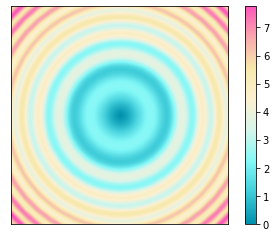

In [27]:
# Checking color code
# The code is based on the link in reference (by Kerry Halupka)
# Reference: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

# Create x, y, z
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))

# List of hex codes
hex_list0= ['#0091ad', '#3fcdda', '#83f9f8', '#d6f6eb', '#fdf1d2', '#f8eaad', '#faaaae', '#ff57bb']
hex_list1= ["#8fe2ff","#8dbdff","#5999ff","#3d50ff","#6b01ff","#4800c4","#e200ff"]
hex_list2= ["#0466C8", "#0353A4", "#023E7D", "#002855", "#001845", "#001233", "#33415C", "#5C677D", "#7D8597", "#979DAC"]
hex_list3= ["#B7094C", "#A01A58", "#892B64", "#723C70", "#5C4D7D", "#455E89", "#2E6F95", "#1780A1", "#0091AD"]
hex_list4= ["#25CED1", "#FFFFFF", "#FCEADE", "#FF8A5B", "#EA526F"]
hex_list5= ["#EA698B", "#D55D92", "#C05299", "#AC46A1", "#973AA8", "#822FAF", "#6D23B6", "#6411AD", "#571089", "#47126B"]
hex_list6= ["#25CED1", "#00B2CA", "F7C59F", "#FF8A5B", "#086375"]
hex_list7= ["#B76935", "#A56336", "#935E38", "#815839", "#6F523B","#5C4D3C", "#4A473E", "#38413F", "#263C41", "#143642"]
hex_list8= ["#522E38", "#E05780", "#FF9EBB", "#A06CD5", "#3C096C", "#B298DC", "#979DAC", "#5C677D", "#0D1B2A"]
hex_list9= ["#FF595E", "#FFCA3A", "#8AC926", "#1982C4", "#6A4C93"]
hex_list10=["#390099", "#9E0059", "#FF0054", "#FF5400", "#FFBD00"]
hex_list11=["#70D6FF", "#FF70A6", "#FF9770", "#FFD670", "#E9FF70"]
hex_list12=["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6", "#EE9B00", "#CA6702", "#BB3E03", "#AE2012", "#9B2226"]
hex_list13=["#004B23", "#006400", "#007200", "#008000", "#38B000", "#70E000", "#9EF01A", "#CCFF33"]
hex_list14=["#90F1EF", "#FFD6E0", "#FFEF9F", "#C1FBA4", "#7BF1A8"]
hex_list15=["#3D348B", "#7678ED", "#F7B801", "#F18701", "#F35B04"]
hex_list16=["#54478C", "#2C699A", "#048BA8", "#0DB39E", "#16DB93", "#83E377", "#B9E769", "#EFEA5A", "#F1C453", "#F29E4C"]
hex_list17=["#EE6055", "#60D394", "#AAF683", "#FFD97D", "#FF9B85"]
hex_list18=["#00A6FB" ,"#0582CA", "#006494", "#003554", "#051923"]
hex_list19=["#f79256ff", "#fbd1a2ff", "#7dcfb6ff", "#00b2caff", "#1d4e89ff"]
hex_list20=["#083d77ff", "#ebebd3ff", "#f4d35eff", "#ee964bff", "#f95738ff"]
hex_list21=["#1d4e89ff", "#fbd1a2ff", "#7dcfb6ff", "#00b2caff", "#1d4e89ff"]
hex_list22=["#072ac8ff", "#1e96fcff", "#a2d6f9ff", "#fcf300ff", "#ffc600ff"]
hex_list23=["#ff499eff", "#d264b6ff", "#a480cfff", "#779be7ff", "#49b6ffff"]
hex_list24=["#d62839ff", "#ba324fff", "#175676ff", "#4ba3c3ff", "#cce6f4ff"]
hex_list25=["2d728f","3b8ea5","f5ee9e","f49e4c","ab3428"]
hex_list26=["9b5de5","f15bb5","fee440","00bbf9","00f5d4"]
hex_list27=["ef476f","ffd166","06d6a0","118ab2","073b4c"]
hex_list28=["001219","005f73","0a9396","94d2bd","e9d8a6","ee9b00","ca6702","bb3e03","ae2012","9b2226"]
hex_list29=["2d00f7","6a00f4","8900f2","a100f2","b100e8","bc00dd","d100d1","db00b6","e500a4","f20089"]
hex_list30=["54478c","2c699a","048ba8","0db39e","16db93","83e377","b9e769","efea5a","f1c453","f29e4c"]
hex_list31=["2d728f","3b8ea5","f5ee9e","f49e4c","ab3428"]
hex_list32=["d62839","ba324f","175676","4ba3c3","cce6f4"]
hex_list33=["ff499e","d264b6","a480cf","779be7","175676"]
hex_list34=["0c0a3e","7b1e7a","b33f62","f9564f","f3c677"]
hex_list35=["ee6055","60d394","aaf683","ffd97d","ff9b85"]
hex_list36=["247ba0","70c1b3","b2dbbf","f3ffbd","ff1654"]
hex_list37=["03071e","370617","6a040f","9d0208","d00000","dc2f02","e85d04","f48c06","faa307","ffba08"]
hex_list38=["3d5a80","98c1d9","e0fbfc","ee6c4d","293241"]
hex_list39=["8ecae6","219ebc","023047","ffb703","fb8500"]
hex_list40=["9b5de5","f15bb5","fee440","F9C74F","00bbf9","184E77"]
hex_list41=["0c0a3e","7b1e7a","b33f62","f9564f","f3c677"]
hex_list42=["2d728f","3b8ea5","f5ee9e","f49e4c","ab3428"]
hex_list43=["6e44ff","b892ff","ffc2e2","ff90b3","BA324F"]
hex_list44=["000814","001d3d","003566","ffc300","ffd60a"]
hex_list45=["001427","708d81","f4d58d","bf0603","8d0801"]

# If the reversed hex code color is required just using index [::-1]. 
# For example, the reversed color of hex_list0 is hex_list0[::-1]

# Plot colors
fig, ax = plt.subplots(1, 1)
im = ax.imshow(z, cmap=get_gradient_cmap(hex_list0))
fig.colorbar(im)

# Remove axes
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

## 5.2. Plotting with map

In [28]:
def round_down(number, decimals=0):
    '''This function is to round down the number. This code is based on the link in reference (by Priyankur Sarkar)
    Reference:  https://www.knowledgehut.com/blog/programming/python-rounding-numbers
    Arguments:
                number:
                        Number needs rounding down
                decimals:
                        Number of decimals that the number can be rounded down to
    Return:
                rounded_down_number:
                        Number that is rounded down
    '''
    rounded_down_number = np.floor(number * (10 ** decimals)) / (10 ** decimals)
    return rounded_down_number

In [29]:
# Create a function to plot the water depth values along with the map
def plotting_map(filtered_data_func, calculation_option, axis, 
                 hex_list_func, colorbar_position, 
                 extend_colorbar=None):
    '''This function is to plot water depth on basemap
    References: https://stackoverflow.com/questions/41897544/make-a-contour-plot-by-using-three-1d-arrays-in-python
                https://stackoverflow.com/questions/44669616/contour-in-matplotlib-does-not-plot-specified-number-of-contours
                https://stackoverflow.com/questions/48487346/filled-contour-using-class-labels
                https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/tricontour_smooth_user.html#sphx-glr-gallery-images-contours-and-fields-tricontour-smooth-user-py
                https://www.python-course.eu/matplotlib_contour_plot.php
                https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
                https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/
                https://alex.miller.im/posts/contour-plots-in-python-matplotlib-x-y-z/
                
                https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
                https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tricontourf.html
                https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tricontour.html#matplotlib.pyplot.tricontour
                
                https://contextily.readthedocs.io/en/latest/providers_deepdive.html
                https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib
                https://www.tutorialspoint.com/how-do-i-adjust-offset-the-colorbar-title-in-matplotlib
                https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
                
                https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
                https://kaleidoscopicdiaries.wordpress.com/2015/05/30/distance-between-axes-label-and-axes-in-matplotlib/
                https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html
                https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills
                
                https://matplotlib.org/stable/gallery/axes_grid1/demo_colorbar_with_axes_divider.html
                https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    Arguments:
                filtered_data_func:
                                    Filtered dataset contains nodata values as -999
                calculation_option:
                                    "mean" means to calculate mean
                                    "sd" means to calculate standard deviation
                                    "cv" means to calculate coefficient of variation
                                    "cell" means to calculate probability of each pixel being inundated
                axis:
                                    Subplot ordinal number of the contour map on the big plot
                hex_list_func:
                                    A list of hex code colors (including or not including #)
                extend_colorbar:
                                    Whether having or not having arrow to indicate the larger or smaller values in colorbar
                colorbar_position:
                                    "horizontal" or "vertical"
    '''
    # Titles and labels:
    if calculation_option != 'cell':
        # Title for colorbar
        name_map = f"{calculation_option.capitalize()} of water depth (m)"
        
        # Title for contour map
        axis.set_title(f"{name_map} of water depth", pad=25, fontsize=25, fontweight='bold')
        axis.set_xlabel("NZTM, east (m)", fontsize=20, labelpad=38)
        axis.set_ylabel("NZTM, north (m)", fontsize=20, labelpad=38, rotation=-270)
        
        # Level information
        min_map_level = round_down(np.min(filtered_data_func[f'{calculation_option}'][filtered_data_func[f'{calculation_option}'] != -999]), 1)
        max_map_level = np.max(filtered_data_func[f'{calculation_option}'][filtered_data_func[f'{calculation_option}'] != -999] - 1)
        map_level = np.arange(min_map_level, max_map_level, 0.1)
        
    else:
        
        # Title for colorbar
        name_map = "Probability of each location being inundated (%)"
        
        # Title for contour map
        axis.set_title("Probability of each location being inundated", pad=25, fontsize=25, fontweight='bold')
        axis.set_xlabel("NZTM, east (m)", fontsize=20, labelpad=38)
        axis.set_ylabel("NZTM, north (m)", fontsize=20, labelpad=38, rotation=-270)
        
        # Max level
        min_map_level = 0
        max_map_level = 102
        map_level = np.arange(min_map_level, max_map_level, 1)
    
    # x, y, z coordinates information
    x_func = filtered_data_func['x']
    y_func = filtered_data_func['y']
    z_func = filtered_data_func[f'{calculation_option}']
    
    # Build up contour map
    contour_map_func = axis.tricontourf(x_func, y_func, z_func, levels=map_level,
                                        cmap=get_gradient_cmap(hex_list_func),
                                        alpha=1, antialiased=True, extend=extend_colorbar)
    
    # Improve visualisation of map (x, y) axes
    axis.tick_params(direction='out', length=8, pad=10)                   # For x, y axes' ticks
    axis.yaxis.offsetText.set_fontsize(12)                                # For 1e6 if there is no axis.ticklabel_format(useOffset=False, style='plain')
    axis.xaxis.offsetText.set_fontsize(12)                                # For 1e6 if there is no axis.ticklabel_format(useOffset=False, style='plain')
    
    for item in (axis.get_xticklabels() + axis.get_yticklabels()):        # For x, y ticks' labels
        item.set_fontsize(15)
    
    # Remove grid background lines (including x, y lines)
    axis.grid(False)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    
    # Remove whitelines
    for color_line in contour_map_func.collections:
        color_line.set_edgecolor("face")
    
    # Call the map
    ctx.add_basemap(ax=axis, crs=2193, 
                    source=ctx.providers.OpenStreetMap.BlackAndWhite, 
                    attribution_size=10, zoom=17)
    
    # Scale bar
    map_scalebar = ScaleBar(10, font_properties={'weight': 'bold', 'size': 15},
                            pad=0.5,
                            box_color=None,
                            box_alpha=0,
                            color='k',
                            scale_formatter=lambda value, unit: f'{value} {unit}')

    axis.add_artist(map_scalebar)
    
    # Colorbar
    if colorbar_position == 'horizontal':
        # Set up colorbar position
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("bottom", size="3%", pad=1.8)
        
        map_colorbar = fig.colorbar(contour_map_func, orientation=colorbar_position, cax=cax, ax=axis)
        map_colorbar.ax.tick_params(axis='x', direction='out', length=6, pad=10, labelsize=15)
        
        # Set up colorbar title
        map_colorbar.set_label(name_map, labelpad=30, fontsize=20)
        
    else:
        # Set up colorbar position
        cax = fig.add_axes([ax.get_position().x1 + 0.02,
                            ax.get_position().y0, 0.02,
                            ax.get_position().height])
        
        map_colorbar = fig.colorbar(contour_map_func, cax=cax, pad=5, ax=axis)
        map_colorbar.ax.tick_params(axis='y', direction='out', length=6, pad=10, labelsize=15)
        
        # Set up colorbar title
        map_colorbar.set_label(name_map, rotation=270, labelpad=38, fontsize=20)

In [30]:
def plotting_histogram(filtered_data_func, calculation_option, 
                       axis, hex_list_func):
    '''This function is to plot histogram of information regarding water depth
    Reference:  https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
                https://stdworkflow.com/67/attributeerror-rectangle-object-has-no-property-normed-solution
    Arguments:
            filtered_data_func:
                                Filtered dataset contains nodata values as -999
            calculation_option:
                                "mean" means to calculate mean
                                "sd" means to calculate standard deviation
                                "cv" means to calculate coefficient of variation
                                "cell" means to calculate probability of each pixel being inundated
            axis:
                                Subplot ordinal number of the contour map on the big plot
            hex_list_func:
                                A list of hex code colors (including or not including #)    
    '''
    # Get z values
    z_func = filtered_data_func[f'{calculation_option}']
    
    # Select colormap
    hist_cm = get_gradient_cmap(hex_list_func)
    
    # Get the histogram
    hist_y_axis, hist_x_axis = np.histogram(z_func[z_func != -999], 50, density=False)

    hist_x_span = hist_x_axis.max() - hist_x_axis.min()

    hist_color = [hist_cm(((hist_x_val - hist_x_axis.min()) / hist_x_span)) for hist_x_val in hist_x_axis]

    axis.bar(hist_x_axis[:-1],
             hist_y_axis,
             color = hist_color,
             width = hist_x_axis[1] - hist_x_axis[0])

    for hist_item in (axis.get_xticklabels() + axis.get_yticklabels()):
        hist_item.set_fontsize(15)
    
    # Remove grid background lines (including x, y lines)
    axis.grid(False)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    
    # Set titles and labels
    if calculation_option != 'cell':
        # Title for colorbar
        name_map = f"{calculation_option.capitalize()} of water depth (m)"
        
        # Title for contour map
        axis.tick_params(direction='out', length=8, pad=10)
        axis.set_title(f"Histogram of {name_map} of water depth", pad=25, fontsize=25, fontweight='bold')
        axis.set_xlabel('Mean of depth values (m)', fontsize=20, labelpad=38)
        axis.set_ylabel('Frequency', fontsize=20, labelpad=38)
        
    else:
        
        # Title for colorbar
        name_map = "Probability of each location being inundated (%)"
        
        # Title for contour map
        axis.tick_params(direction='out', length=8, pad=10)
        axis.set_title("Histogram of probability of each location being inundated", pad=25, fontsize=25, fontweight='bold')
        axis.set_xlabel("Probability of each location being inundated (%)", fontsize=20, labelpad=38)
        axis.set_ylabel("Frequency", fontsize=20, labelpad=38)

-------------------------------------------------------------------------------------------------------------------------------

### Execute

In [31]:
# a = xyz_array("c", combination_number0, 36)
# a

In [32]:
%%time
combination_number0 = f"angle_0_x_0_y_0"
clipped_dataset = raster_array_to_shapefile("c", combination_number0, 72)

[1767313. 1767323. 1767333. ... 1774163. 1774173. 1774183.]
[5469562. 5469562. 5469562. ... 5476432. 5476432. 5476432.]
[0. 0. 0. ... 0. 0. 0.]
[[1767673. 5471672.       0.]
 [1767683. 5471672.       0.]
 [1767693. 5471672.       0.]
 ...
 [1773723. 5474222.       0.]
 [1773733. 5474222.       0.]
 [1773743. 5474222.       0.]]
Wall time: 4min 27s


In [35]:
# Set up the angle
angle_start = 0
angle_end = 90
angle_interval = 90

# Set up the translation
value_start = 0
value_end = 0
value_interval = 1

In [36]:
data = {"x_coord": clipped_dataset[:, 0],
        "y_coord": clipped_dataset[:, 1]}

for angle_value in range(angle_start, angle_end+1, angle_interval):
    for value_x in range(value_start, value_end+1, value_interval):
        for value_y in range(value_start, value_end+1, value_interval):
            # Set the name of each translation
            combination_number = f"angle_{angle_value}_x_{value_x}_y_{value_y}"
            print(combination_number)
            
            start = time.time()
            data[f"{combination_number}"] = get_flowdepth_value("c", combination_number, 72)
            end = time.time()
            print("{0} angle: {1} and x: {2} and y: {3} {0}".format("-"*30, angle_value, value_x, value_y))
            print("Running time:", end-start)
            print("-"*90)
            print("\n")

angle_0_x_0_y_0
------------------------------ angle: 0 and x: 0 and y: 0 ------------------------------
Running time: 132.2824890613556
------------------------------------------------------------------------------------------


angle_90_x_0_y_0
------------------------------ angle: 90 and x: 0 and y: 0 ------------------------------
Running time: 129.8894488811493
------------------------------------------------------------------------------------------




In [ ]:
print(len(data['angle_0_x_0_y_0']))
print(len(data['angle_45_x_0_y_0']))
print(len(data['angle_90_x_0_y_0']))

In [37]:
full_data = pd.DataFrame(data = data)
full_data

,x_coord,y_coord,angle_0_x_0_y_0,angle_90_x_0_y_0
0,1.767673e+06,5.471672e+06,0.0,0.0
1,1.767683e+06,5.471672e+06,0.0,0.0
2,1.767693e+06,5.471672e+06,0.0,0.0
3,1.767703e+06,5.471672e+06,0.0,0.0
4,1.767713e+06,5.471672e+06,0.0,0.0
...,...,...,...,...
155643,1.773703e+06,5.474222e+06,0.0,0.0
155644,1.773713e+06,5.474222e+06,0.0,0.0
155645,1.773723e+06,5.474222e+06,0.0,0.0
155646,1.773733e+06,5.474222e+06,0.0,0.0


In [38]:
print(full_data['angle_0_x_0_y_0'][40])
print(full_data['angle_90_x_0_y_0'][40])

0.0
0.0


In [ ]:
for i in range(13824):
    if full_data['angle_0_x_0_y_0'][i] != full_data['angle_90_x_0_y_0'][i]:
        print(i)

In [39]:
dif = []
for i in range(full_data.shape[0]):
    a = full_data['angle_90_x_0_y_0'][i] - full_data['angle_0_x_0_y_0'][i]
    if a !=0:
#         print(i)
        dif.append(a)

-2.1633043
2.1095729


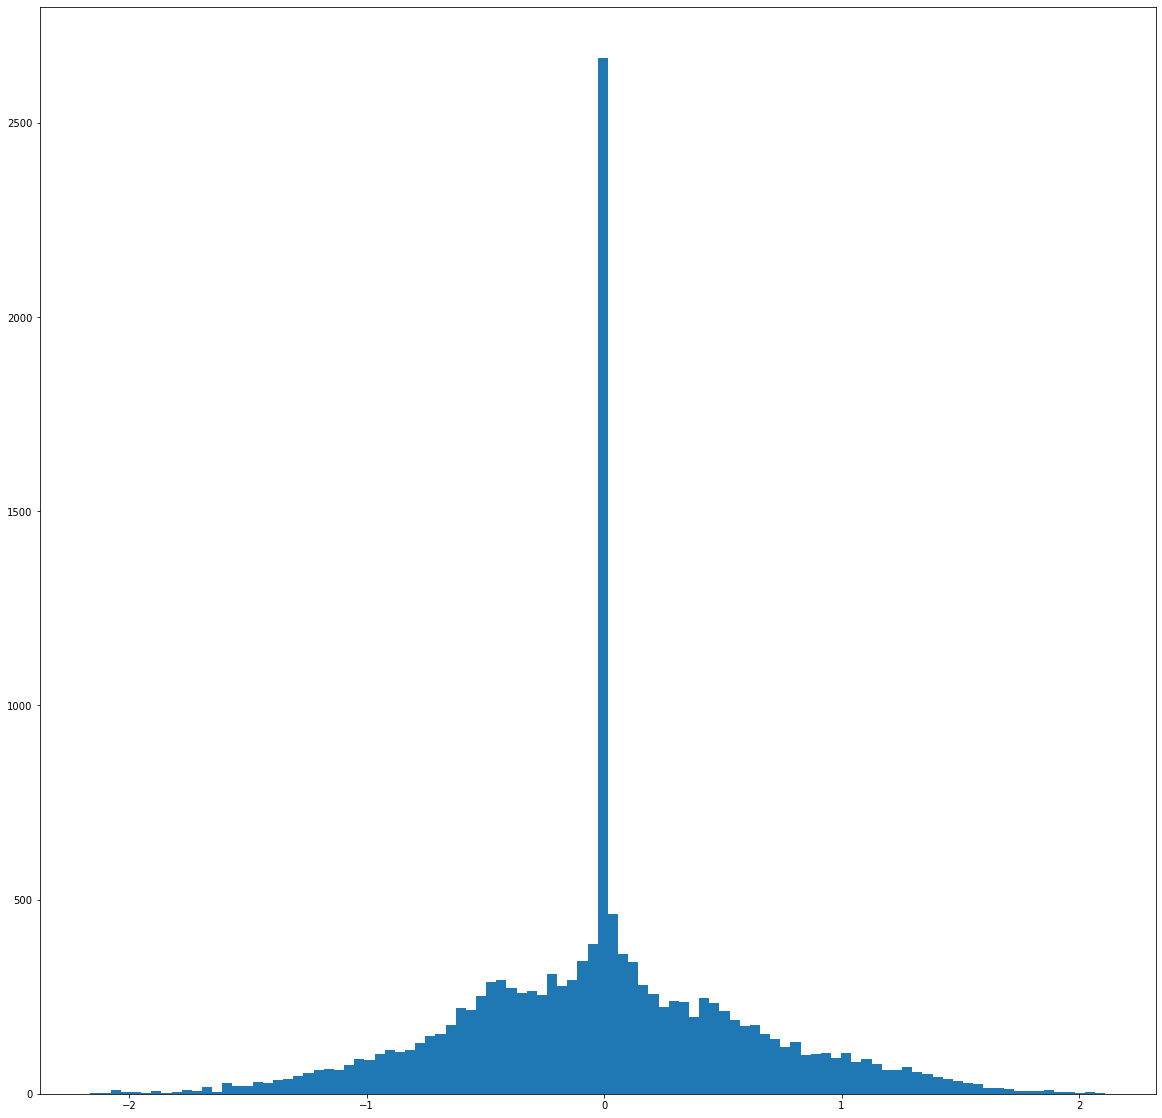

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

print(min(dif))
print(max(dif))
ax.hist(dif, bins=100);

In [ ]:
np.array(full_data['angle_90_x_0_y_0'])

In [ ]:
# Checking if the same length
for angle_value in range(angle_start, angle_end+1, angle_interval):
    for value_x in range(value_start, value_end+1, value_interval):
        for value_y in range(value_start, value_end+1, value_interval):
            if len(data[f"angle_{angle_value}_x_{value_x}_y_{value_y}"]) != 169728:
                print(f"angle_{angle_value}_x_{value_x}_y_{value_y}")
                print(len(data[f"angle_{angle_value}_x_{value_x}_y_{value_y}"]))

In [ ]:
# Write into csv file
csv_generation('c', full_data)

------------------------------------------------------------------------------------------------------

In [ ]:
# Checking if it's correct unrotation
import matplotlib.pyplot as plt

plt.scatter(clipped_dataset[:,0], clipped_dataset[:,1], c=np.array(full_data['angle_90_x_0_y_0']), cmap="Blues", s=200)
plt.show()

### Calculation

In [ ]:
data_check1 = pd.read_csv(r'Y:\7_results\un_combination\uncom_csv\version_1\un_combined_file_1_no.csv')
data_check2 = pd.read_csv(r'Y:\7_results\un_combination\uncom_csv\version_1\un_combined_file_1.csv')

In [ ]:
data_check1['angle_0_x_0_y_1']

In [ ]:
data_check2

In [ ]:
# Full data from csv
full_data = pd.read_csv(r'T:\\7_results\un_combination\uncom_csv\version_1\\un_combined_file.csv')

In [ ]:
mean_dataset = filter_dataset(full_data, 'mean', 0.1)
sd_dataset = filter_dataset(full_data, 'sd', 0.1)
cv_dataset = filter_dataset(full_data, 'cv', 0.1)
cell_dataset = filter_dataset(full_data, 'cell', 0.1)

In [ ]:
mean_dataset[mean_dataset['mean']==-999]

In [ ]:
raster_generation('c', cell_dataset['x'], cell_dataset['y'], cell_dataset['cell'], 'cell')

In [ ]:
polygon_generation('c', cell_dataset, 'cell')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
plotting_map(sd_dataset, 'sd', ax, hex_list0, "vertical", None)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
plotting_histogram(sd_dataset, 'sd', ax, hex_list0)

### Building up a map

### Mean

In [ ]:
def contour_plot(data, color_name, plot_name):
    '''This function is to plot the contour map
    References: https://stackoverflow.com/questions/41897544/make-a-contour-plot-by-using-three-1d-arrays-in-python
                https://stackoverflow.com/questions/44669616/contour-in-matplotlib-does-not-plot-specified-number-of-contours
                https://stackoverflow.com/questions/48487346/filled-contour-using-class-labels
                https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/tricontour_smooth_user.html#sphx-glr-gallery-images-contours-and-fields-tricontour-smooth-user-py
                https://www.python-course.eu/matplotlib_contour_plot.php
                https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
                https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/
                https://alex.miller.im/posts/contour-plots-in-python-matplotlib-x-y-z/
                
                https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
                https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tricontourf.html
                https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tricontour.html#matplotlib.pyplot.tricontour
    Arguments:
                data: 
                        dataset contained the values
                color_name:
                        name of color to show the values
                        
                plot_name:
                        name of plot
    '''
    # Create size of plotting background
    fig, ax = plt.subplots(figsize=(20, 15))
    
    # 
    

In [ ]:
# No lines
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 15))

levels = np.arange(0.1, 7, 0.01)
cmap = cm.get_cmap(name='viridis', lut=None)

contour_sd = ax.tricontourf(data["x_coord"], data["y_coord"], mean_dataset["mean"], levels=levels,
                            cmap=cmap)

plt.title("Mean Flowdepth")
# plt.colorbar(contour_mean)
plt.colorbar(contour_sd)
plt.show()

In [ ]:
# Having lines, but no color for lines
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 15))

levels = np.arange(0., np.ceil(np.max(mean_data['mean']))+0.5, 0.01)
cmap = cm.get_cmap(name='terrain', lut=None)

a = ax.tricontourf(data["x_coord"], data["y_coord"], mean_data["mean"], levels=levels, cmap=cmap)
ax.tricontour(data["x_coord"], data["y_coord"], mean_data["mean"], levels=levels, cmap=cmap,
              linestyles='dashdot')

plt.title("Depth contour")
plt.colorbar(a)
plt.show()

In [ ]:
color_length = np.arange(0., 8., 0.1).shape[0]
color_range = np.linspace(0., 1., color_length).tolist()
color = [str(color_range[i]) for i in range(len(color_range))]

In [ ]:
# Having lines, but no color for lines
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 15))

levels = np.arange(0., np.ceil(np.max(mean_data['mean']))+0.5, 0.1)
linewidths = np.arange(1.5, 0., -0.1)
cmap = cm.get_cmap(name='terrain_r', lut=None)

a = ax.tricontourf(data["x_coord"], data["y_coord"], mean_data['mean'], levels=levels, cmap=cmap)
ax.tricontour(data["x_coord"], data["y_coord"], mean_data['mean'], levels=levels, colors=color,
              linestyles='dashdot',
              linewidths=linewidths)

plt.title("Standard deviation Flowdepth Contour")
plt.colorbar(a)
plt.show()

In [ ]:
a = np.min(mean_data['mean'][mean_data['mean']>np.min(mean_data['mean'])])

In [ ]:
b = np.min(mean_data['mean'][mean_data['mean']>a])
b

In [ ]:
c = np.min(mean_data['mean'][mean_data['mean']>b])
c

In [ ]:
np.min(mean_data['mean'][mean_data['mean']>0.001])

In [ ]:
# Have lines and colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar


fig, ax = plt.subplots(figsize=(30, 30))

levels = np.arange(0, np.ceil(np.max(mean_data['mean']))+0.5, 0.1)
linewidths = np.arange(1.5, 0.5, -0.1)
cmap = cm.get_cmap(name='Blues', lut=None)

a = ax.tricontourf(data["x_coord"], data["y_coord"], copy_mean_data["mean"], levels=levels, cmap=cmap, alpha=0.6, antialiased = True)
ax.tricontour(data["x_coord"], data["y_coord"], copy_mean_data["mean"], levels=levels, colors=['0', '0.125', '0.25', '0.375',
                                                                                               '0.5', '0.675', '0.75', '0.875', '1'], 
              linestyles='dashdot',
              linewidths=linewidths,
              alpha=0.3)



ctx.add_basemap(ax=ax, crs=2193, source=ctx.providers.OpenTopoMap)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

ax.set_title("Water Depth (Mean) Contour Map - Area: Waikanae River", pad=25, fontsize=30)
cbar = plt.colorbar(a, cax=cax)
cbar.set_label("Depth values (m)", rotation=270, labelpad=38, fontsize=28)
cbar.ax.tick_params(axis = 'y', direction='out', length=6, pad=10, labelsize=18)

ax.set_xlabel("NZTM, east (m)", fontsize=28, labelpad=38)
ax.set_ylabel("NZTM, north (m)", fontsize=28, labelpad=38, rotation=-270)
ax.tick_params(direction='out', length=8, pad=10)


# ax.rc('xtick', labelsize=18)
# ax.rc('ytick', labelsize=18)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

ax.ticklabel_format(useOffset=False, style='plain')

scalebar = ScaleBar(10, font_properties={'size': 25},
                    pad=1,
                    box_color=None,
                    box_alpha=0,
                    color='mediumblue',
                    scale_formatter=lambda value, unit: f'{value} {unit}')
ax.add_artist(scalebar)

plt.savefig('Z:\\Trial\\Example\\foo.png')

plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### Zero to nodata value

In [ ]:
copy_mean_data = mean_data.copy()

copy_mean_data.loc[copy_mean_data['mean'] == 0, ['mean']] = -999

copy_mean_data[32:33]

In [ ]:
# Have lines and colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 15))

cmap = cm.get_cmap(name='YlOrRd', lut=None)

a = ax.scatter(data["x_coord"], data["y_coord"], c=copy_mean_data['mean'], marker='s', cmap=cmap, s=80, linewidth=0.3, edgecolor='k', alpha=0.3)

ax.set_xlim([np.min(data['x_coord']), np.max(data['x_coord'])])
ax.set_ylim([np.min(data['y_coord']), np.max(data['y_coord'])])

ctx.add_basemap(ax=ax, crs=2193, source=ctx.providers.OpenTopoMap)

plt.title("Mean Flowdepth Contour")
plt.colorbar(a)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### Create raster/polygon

### Mean

### Polygon - Shapefile

In [ ]:
rc_origin = rasterio.open(fr"{combined_nc_raster_path}\\generated_dem_no_padding.nc")
rc_origin_array = rc_origin.read(1)
rc_origin_transform = rc_origin.transform
rc_origin_crs = rc_origin.crs

# Extract parameters: id and depth
id_pixels = np.arange(rc_origin_array.size).reshape(rc_origin_array.shape)
mean_list = copy_mean_data['mean'].tolist()


# Vectorise features
vectors = rasterio.features.shapes(source = id_pixels.astype(np.int16),
                                   transform = rc_origin_transform)

vectors_list = list(vectors)

# Get geometry
polygons_geometry = [shape(polygon) for polygon, value in vectors_list]


# Get id
id_polygon = [id_val for id_poly, id_val in vectors_list]


# Create database
polygon_mean = {'id': id_polygon,
                "mean": mean_list}

polygon_pdf = gpd.GeoDataFrame(data = polygon_mean,
                               geometry = polygons_geometry,
                               crs = rc_origin_crs)
polygon_pdf.plot(column='mean', cmap='terrain')

In [ ]:
poly_sample = polygon_pdf.to_crs(epsg=3857)

In [ ]:
import contextily as ctx
# from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(15, 15))

p1 = polygon_pdf.plot(ax=ax, column='mean', cmap='YlOrRd', alpha=0.7, legend=True)
ctx.add_basemap(ax=ax, crs=2193, source=ctx.providers.OpenTopoMap)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Raster

In [ ]:
mean_array_1d = np.dstack((full_data['x_coord'], full_data['y_coord'], mean_data['mean']))
pd_data = pd.DataFrame(dict(x=mean_array_1d[0][:,0], 
                            y=mean_array_1d[0][:,1], 
                            z=mean_array_1d[0][:,2]))
xcol, ycol, zcol = 'x', 'y', 'z'

pd_data_sorted = pd_data.sort_values(by=[xcol, ycol])
xvals = np.round(pd_data_sorted[xcol].unique(), 3)
yvals = np.round(pd_data_sorted[ycol].unique(), 3)
zvals = pd_data_sorted[zcol].values.reshape(len(xvals), len(yvals)).T

In [ ]:
arr = xarray.DataArray(
    data=zvals,
    dims=['y', 'x'],
    coords={
        "x": (['x'], xvals2),
        "y": (['y'], yvals2)
    },
    attrs=rc_nc.attrs
)
arr.rio.write_crs(2193)
arr.rio.write_nodata(0, inplace=True)

In [ ]:
arr.rio.to_raster(r"Z:\\Trial\\Example\\flowdepth_raster4.tiff")

### Another plot

### mean and coordinates

In [ ]:
full_data.shape[0]

In [ ]:
point_coordinates = [Point(full_data['y_coord'][i], full_data['x_coord'][i]) for i in range(full_data.shape[0])]

new_data = {"mean": mean_data['mean']}

point_dataframe = gpd.GeoDataFrame(data = new_data,
                                   geometry = point_coordinates,
                                   crs = 2193)
point_dataframe.plot()

### Folium to plot raster

In [ ]:
x_range = {'y': xvals}
y_range = {'x': yvals}

y_df = pd.DataFrame(x_range)
x_df = pd.DataFrame(y_range)

In [ ]:
lon = p(y_df['y'], inverse=True)

In [ ]:
import pyproj

p = pyproj.Proj("+proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

def convert_to_latlon(df, p):
    lon, lat = p(df['x'], df['y'], inverse=True)
    df['lat'] = lat
    df['lon'] = lon
    return df

In [ ]:
mean_df_convert = mean_df.apply(convert_to_latlon, p=p, axis=1)
mean_df_convert['lat'] = np.round(mean_df_convert['lat'], 4)
mean_df_convert['lon'] = np.round(mean_df_convert['lon'], 4)

In [ ]:
mean_array_lonlat = np.dstack((mean_df_convert['lat'], mean_df_convert['lon'], mean_df_convert['mean']))
pd_data1 = pd.DataFrame(dict(x=mean_array_lonlat[0][:,0], 
                             y=mean_array_lonlat[0][:,1],
                             z=mean_array_lonlat[0][:,2]))

xcol, ycol, zcol = 'x', 'y', 'z'

pd_data_sorted1 = pd_data1.sort_values(by=[xcol, ycol])
xvals1 = pd_data_sorted1[xcol].unique()
yvals1 = pd_data_sorted1[ycol].unique()
zvals1 = pd_data_sorted1[zcol].values.reshape(len(xvals), len(yvals)).T

In [ ]:
yvals1.shape

In [ ]:
mean_df_convert

In [ ]:
import folium

m = folium.Map(location=[-40.88, 175.04500], zoom_start=14)

m

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

levels = np.arange(0., np.ceil(np.max(mean_data['mean']))+0.5, 0.1)
linewidths = np.arange(1.5, 0., -0.1)
cmap = cm.get_cmap(name='Blues', lut=None)

contour_mean = ax.contourf(xvals1, yvals1, zvals1, cmap=cmap)

plt.title("Mean Flowdepth Contour")
plt.colorbar(contour_mean)
plt.show()

In [ ]:
import geojsoncontour

# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contour_m
)

# Set up the map placeholder
geomap1 = folium.Map(location=[-40.88, 175.04500], zoom_start=14)

# Plot the contour on Folium map
folium.GeoJson(
    geojson
).add_to(geomap1)



# Add the legend to the map
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap1)
geomap1


In [ ]:
coord_data = {'y': full_data['y_coord'],
              'x': full_data['x_coord'],
              'mean': mean_data['mean']}

coord_df = pd.DataFrame(coord_data)

coord_df_0 = coord_df.loc[~((coord_df['mean']==np.nan))]

coord_df_0

In [ ]:
np.nan

In [ ]:
import pyproj

p = pyproj.Proj("+proj=tmerc +lat_0=0 +lon_0=173 +k=0.9996 +x_0=1600000 +y_0=10000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

def convert_to_latlon(df, p):
    lon, lat = p(df['x'], df['y'], inverse=True)
    df['lat'] = lat
    df['lon'] = lon
    return df

In [ ]:
coord_df_0_convert = coord_df_0.apply(convert_to_latlon, p=p, axis=1)
coord_df_0_convert

In [ ]:
coord_df[['lat', 'lon']].values

In [ ]:
from folium import plugins
coord_array = coord_df_0_convert[['lat', 'lon']].values
m = folium.Map(location=[-40.88, 175.04500], zoom_start=15)
m.add_children(plugins.HeatMap(coord_array, radius=11))
m

In [ ]:
np.min(coord_df_0_convert['mean'])

In [ ]:
# Have lines and colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(20, 15))

levels = np.arange(0, np.ceil(np.max(mean_data['mean']))+0.5, 0.1)
linewidths = np.arange(1.5, 0.1, -0.1)
cmap = cm.get_cmap(name='Blues', lut=None)

a = ax.tricontourf(coord_df_0_convert["x"], coord_df_0_convert["y"], coord_df_0_convert['mean'], levels=levels, cmap=cmap)
ax.tricontour(coord_df_0_convert["x"], coord_df_0_convert["y"], coord_df_0_convert['mean'], levels=levels, colors=['0', '0.125', '0.25', '0.375',
                                                                                                                   '0.5', '0.675', '0.75', '0.875', '1'], 
              linestyles='dashdot',
              linewidths=linewidths)

plt.title("Mean Flowdepth Contour")
plt.colorbar(a)
plt.show()

In [ ]:
m.add_children(folium.raster_layers.ImageOverlay(dataframe, opacity=0.5,
                                                 bounds = [[-40.88576, 175.03205], [-40.87013, 175.05304]]))
m

In [ ]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

In [ ]:
path = gpd.datasets.get_path('nybb')
df = gpd.read_file(path)
df.head()

In [ ]:
df.plot(figsize=(6, 6))
plt.show()

In [ ]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = df.to_crs(epsg=4326)
print(df.crs)
df.head()

In [ ]:
f = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
f

In [ ]:
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j,
#                            style_function=lambda x: {'fillColor': 'orange'})
#     folium.Popup(r['BoroName']).add_to(geo_j)
#     geo_j.add_to(f)
# f
    print(sim_geo)

-------------------------------------------------------------------------------

### Fiona

In [ ]:
import fiona
from shapely.geometry import shape

polygons_check = fiona.open(fr"{unrotated_path}\shapefile_45\flowdepth_unrotated_45_at_5.shp")
values_polygons_check = [poly for poly in polygons_check]

points_check = fiona.open(fr"Z:\Trial\Example\Point_clip.shp")
values_points_check = [pt for pt in points_check]

In [ ]:
for position, polygon in enumerate(values_polygons_check):
    print(shape(polygon['geometry']).bounds)

In [ ]:
for l in idx.intersection(point.coords[0]):
    print(l)

In [ ]:
point.intersects(shape(values_polygons_check[j]['geometry']))

In [ ]:
values_polygons_check[8244]["properties"]['depth']

In [ ]:
shape(values_polygons_check[8244]['geometry'])

In [ ]:
for i, pts in enumerate(values_points_check):
    point = shape(pts['geometry'])
    print(point.coords[0])

In [ ]:
%%time
from rtree import index
idx = index.Index()
for position, polygon in enumerate(values_polygons_check):
    idx.insert(position, shape(polygon['geometry']).bounds)
a = []
for i, pts in enumerate(values_points_check):
    point = shape(pts['geometry'])
    
    for j in idx.intersection(point.coords[0]):
        if point.within(shape(values_polygons_check[j]['geometry'])):
#             print("index i - point", i, ":", point)
#             print("index j - polygon", j, ":", shape(values_polygons_check[j]['geometry']))
#             print(point.intersects(shape(values_polygons_check[j]['geometry'])))
            print(values_polygons_check[j]["properties"]['depth'])
            a.append(values_polygons_check[j]["properties"]['depth'])

------------------------------------------------------------------------------------------------------

### Checking

In [ ]:
# Checking if it's correct unrotation
import matplotlib.pyplot as plt
def plot_dataset(dataset_plot, clip_value=True):
    '''Plotting
    '''
    if clip_value:
        fig, axes = plt.subplots(figsize=(20,20))
        plot = plt.scatter(dataset_plot[:,0],
                           dataset_plot[:,1],
                           c=dataset_plot[:,2], cmap="Blues", s=200)
        fig.colorbar(plot)    
    else:
        fig, axes = plt.subplots(figsize=(20,20))
        plot = plt.scatter(dataset_plot[:,0],
                           dataset_plot[:,1],
                           c=dataset_plot[:,2], cmap="Blues", s=200)
        fig.colorbar(plot)

In [ ]:
plot_dataset(zero_raster_clip, True)